In [5]:
%% PUPIL PREPROCESSING
%
% 1. convert edf file to asc
% 2. create a FieldTrip-style data structure
% 3. interpolate Eyelink-defined and additionally detected blinks
% (optional): regress out blink- and saccade-linked pupil response
% 4. epoch using a custom trial-definition function
% 5. plot event-related pupil responses
%
% Anne Urai, 2016

% setup path
clear; clc; close all;
thispath = '~/Dropbox/code/pupilTutorial/';
addpath(thispath);

% first, define the asc filename
edfFile = 'EL_P22_s5_b1_2015-06-28_11-14-27.edf';
ascFile = regexprep(edfFile, 'edf', 'asc');

% set path to FieldTrip - get this from http://www.fieldtriptoolbox.org/download
addpath('~/Documents/fieldtrip/');
ft_defaults;


[Warning: Function isrow has the same name as a MATLAB builtin. We suggest you
rename the function to avoid a potential name conflict.] 
[> In path (line 109)
  In addpath (line 88)
  In pymat_eval (line 31)
  In matlabserver (line 24)] 
[Warning: Function isrow has the same name as a MATLAB builtin. We suggest you
rename the function to avoid a potential name conflict.] 
[> In path (line 109)
  In addpath (line 88)
  In pymat_eval (line 31)
  In matlabserver (line 24)]


In [6]:
% ============================================== %
% 1. convert edf file to asc
% ============================================== %

if ~exist(ascFile, 'file'),
    if ismac,
        edf2ascPath = [thispath '/edf2asc-mac'];
    elseif isunix,
        edf2ascPath = [thispath '/edf2asc-linux'];
    else
        error('Sorry, I don''t have an edf2asc converter for Windows')
    end
    % use this converter to create the asc file
    % failsafe mode avoids errors when some samples are missing
    system(sprintf('%s %s -failsafe -input', edf2ascPath, edfFile));
end
assert(exist(ascFile, 'file') > 1, 'Edf not properly converted');


EDF2ASC: EyeLink EDF file -> ASCII (text) file translator
EDF2ASC version 3.1 MacOS X Jul 13 2010 
(c)1995-2009 by SR Research, last modified Jul 13 2010

processing file EL_P22_s5_b1_2015-06-28_11-14-27.edf 
Unexpected event type tag 0. Skipping event 
Unexpected event type tag 0. Skipping event 
=============Preamble of file EL_P22_s5_b1_2015-06-28_11-14-27.edf=============
| DATE: Sun Jun 28 12:46:11 2015                                              |
| TYPE: EDF_FILE BINARY EVENT SAMPLE TAGGED                                   |
| VERSION: EYELINK II 1                                                       |
| SOURCE: EYELINK CL                                                          |
| EYELINK II CL v4.56 Aug 18 2010                                             |
| CAMERA: EyeLink CL-OL HEAD Version 1.0 Sensor=BH9                           |
| SERIAL NUMBER: CLO-ZAC02                                                    |
| CAMERA_CONFIG: ZAC02140.SCD                                

In [7]:
% ============================================== %
% 2. create a FieldTrip-style data structure
% ============================================== %

% read in the asc EyeLink file
asc = read_eyelink_ascNK_AU(ascFile);

% create events and data structure, parse asc
[data, event, blinksmp, saccsmp] = asc2dat(asc);


reading in EL_P22_s5_b1_2015-06-28_11-14-27.asc ...


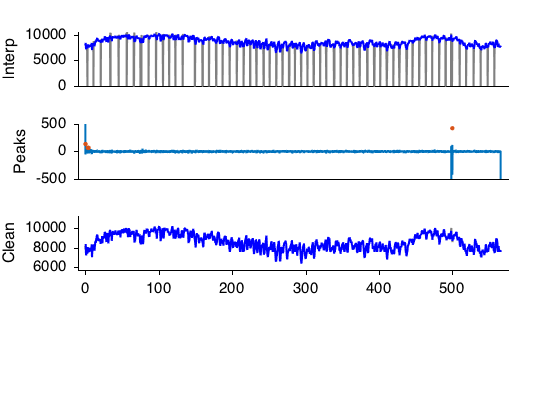

interpolating EL-defined blinks


In [8]:
% ============================================== %
% 3. interpolate Eyelink-defined and additionally detected blinks
% ============================================== %

plotMe = true;
newpupil = blink_interpolate(data, blinksmp, plotMe);
data.trial{1}(find(strcmp(data.label, 'EyePupil')==1),:) = newpupil;


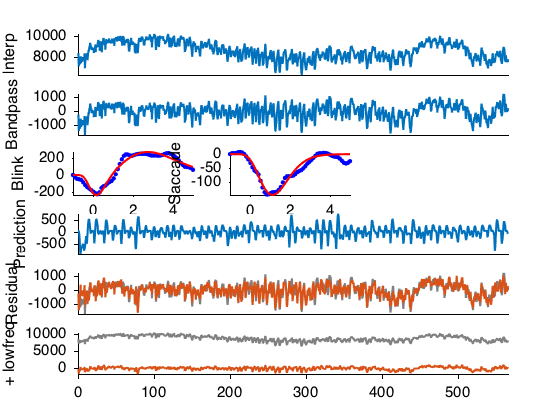

fitting blink double gamma
fitting saccade double gamma


In [9]:
% ============================================== %
% (optional): regress out blink- and saccade-linked pupil response
% see https://tknapen.github.io/science/fir_deconvolution/
% ============================================== %

data = blink_regressout(data, blinksmp, saccsmp, plotMe, 0);

% zscore since we work with the bandpassed signal
data.trial{1}(find(strcmp(data.label, 'EyePupil')==1),:) = ...
    zscore(data.trial{1}(find(strcmp(data.label, 'EyePupil')==1),:));


In [10]:
% ==================================================================
% define trials
% ==================================================================

cfg                         = [];
cfg.dataset                 = ascFile;
cfg.event                   = event;
cfg.trialfun                = 'my_trialfun';
cfg.trialdef.pre            = 0;
cfg.trialdef.post           = 2;
cfg.fsample                 = asc.fsample;
cfg.sj                      = 22;
cfg.session                 = 5;
cfg.block                   = 1;
cfg                         = ft_definetrial(cfg);
% epoch
data                        = ft_redefinetrial(cfg, data);  

% note that this trialfun defines four events per trial: two stimuli (that
% have to be compared), a response, and feedback). We have the trial start
% at fixation and save the samples of each of those events (as well as more
% information about stimulus identity, choice and accuracy) in
% data.trialinfo:
% [fixoffset refoffset stimtype stimoffset resptype respcorrect respoffset ...
% feedbacktype feedbackoffset trlcnt blockcnt session]
% also, this file contains 60 trials which we see is correct.

evaluating trialfunction 'my_trialfun'
found 516 events
created 60 trials
the call to "ft_definetrial" took 0 seconds and required the additional allocation of an estimated 0 MB
the input is raw data with 3 channels and 1 trials
the call to "ft_redefinetrial" took 0 seconds and required the additional allocation of an estimated 17 MB


In [11]:
% ==================================================================
% downsample before saving
% ==================================================================

cfg             = [];
cfg.resamplefs  = 100;
cfg.fsample     = data.fsample;

% see Niels' message on the FT mailing list
samplerows = find(data.trialinfo(1,:)>100); % indices of the rows with sample values (and not event codes)
data.trialinfo(:,samplerows) = round(data.trialinfo(:,samplerows) * (cfg.resamplefs/cfg.fsample));

% use fieldtrip to resample
data    = ft_resampledata(cfg, data);

the input is raw data with 3 channels and 60 trials
the call to "ft_selectdata" took 1 seconds and required the additional allocation of an estimated 13 MB
resampling data
resampling data in trial 28 from 60resampling data in trial 59 from 60resampling data in trial 60 from 60
original sampling rate = 1000 Hz
new sampling rate = 100 Hz
the call to "ft_resampledata" took 1 seconds and required the additional allocation of an estimated 17 MB


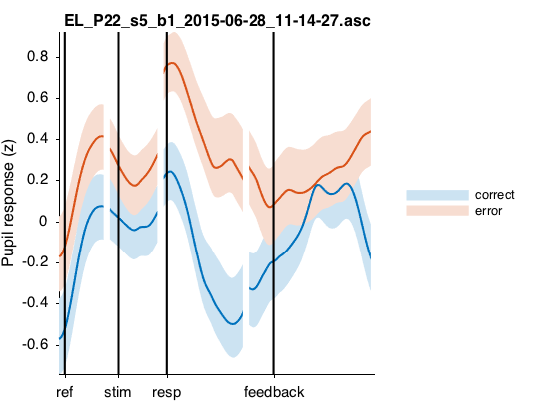

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 58 MB
redefining trial
the input is raw data with 1 channels and 60 trials
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 53 MB
averaging trials
averaging trial 60 of 60
the call to "ft_timelockanalysis" took 0 seconds and required the additional allocation of an estimated 55 MB
redefining trial
the input is raw data with 1 channels and 60 trials
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
averaging trials
averaging trial 60 of 60
the call to "ft_timelockanalysis" took 0 seconds and required the additional allocation of an estimated 0 MB
redefining trial
the input is raw data with 1 channels and 60 trials
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
averaging trials
averaging trial 60 of 60
the call to "ft_timelockanalysis" 

In [12]:
% ==================================================================
% visualize the pupil timecourse
% ==================================================================

cfg                 = [];
cfg.channel         = 'EyePupil';
cfg.trials(1).name  = 'correct';
cfg.trials(1).idx   = find(data.trialinfo(:, 8) == 1);
cfg.trials(2).name  = 'error';
cfg.trials(2).idx   = find(data.trialinfo(:, 8) == 0);

plotEventRelated(cfg, data);
title(ascFile, 'interpreter', 'none');
ylabel('Pupil response (z)');

In [13]:
% ==================================================================
% save file
% ==================================================================

filename = regexprep(ascFile, 'asc', 'mat');
save(filename, 'data');
fprintf('SAVED %s', filename);


Undefined function 'regexpresp' for input arguments of type 'char'.
